In [1]:
!nvidia-smi

Tue Dec 27 01:13:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:73:00.0 Off |                  N/A |
| 30%   39C    P8    25W / 320W |    205MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch.nn as nn
import torch
import tqdm.notebook as tqdm
from IPython import display
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.covariance import EllipticEnvelope
from utils.dataset import load_compiled_data
from utils.head import input_reg, auxiliary_head, mlp_dual

device = torch.device('cuda:0')
reg_camera_1 = input_reg().to(device)
reg_camera_2 = input_reg().to(device)
aux_head = auxiliary_head().to(device)


reg_camera_1.train()
reg_camera_2.train()
aux_head.train()

aircraft-detection custom utils


auxiliary_head(
  (fc_1): Linear(in_features=256, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [13]:
norm_offset = [[20.7227, 271.4375,   9.0000,   5.5000], [5.3496, 248.5000,  10.1094,   4.5000]]
norm_divider = [[1894.2773,  798.0625,  174.2500,   67.5000], [1908.6504,  396.5000,   99.8906,   42.5000]]
train_data = load_compiled_data(ts=[1,2,5],ws=[1],rs=[1,2], offset = norm_offset, divider = norm_divider, trajectory_threshold=[99, 99], device = device)
test_data = load_compiled_data(ts=[1,2,5],ws=[1],rs=[3], offset = norm_offset, divider = norm_divider, trajectory_threshold=[99, 99], device = device)

X_train_1 = train_data['single']['cam_1']['x'].cpu().detach().numpy()
Y_train_1 = train_data['single']['cam_1']['y'][:, 0].cpu().detach().numpy()

X_train_2 = train_data['single']['cam_2']['x'].cpu().detach().numpy()
Y_train_2 = train_data['single']['cam_2']['y'][:, 0].cpu().detach().numpy()

Data Statistic:
          Camera 1:
          Mean: [0.19101892411708832, 0.04624661058187485, 0.23863928020000458, 0.161183699965477]
          Std : [0.24890540540218353, 0.2908424735069275, 0.25386908650398254, 0.2399858832359314]
          
          Camera 2:
          Mean: [0.22113540768623352, 0.12611186504364014, 0.26530587673187256, 0.1844675987958908]
          Std : [0.25682532787323, 0.42740118503570557, 0.2785913050174713, 0.2537324130535126]
          
Data Statistic:
          Camera 1:
          Mean: [0.17446725070476532, -0.012509922496974468, 0.19903448224067688, 0.12914852797985077]
          Std : [0.2501801550388336, 0.3267986476421356, 0.2563011944293976, 0.2437313199043274]
          
          Camera 2:
          Mean: [0.2224167436361313, 0.10093619674444199, 0.26754945516586304, 0.19287000596523285]
          Std : [0.25625601410865784, 0.41074901819229126, 0.2785138487815857, 0.2622748017311096]
          


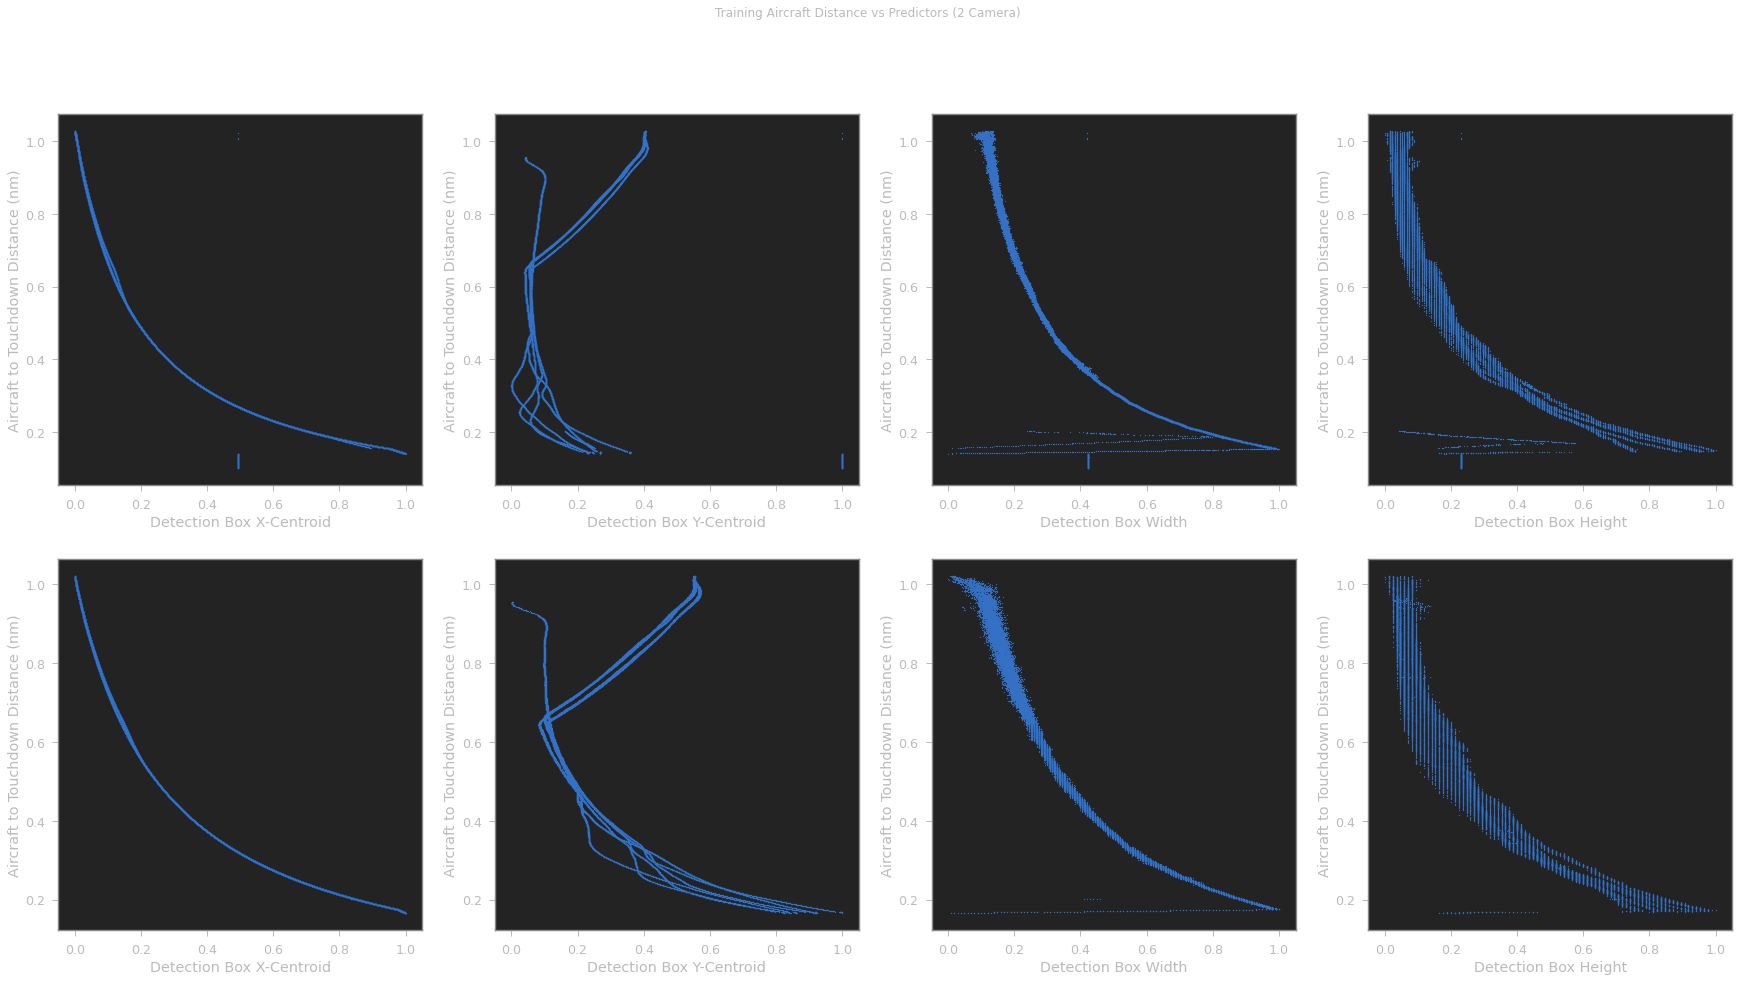

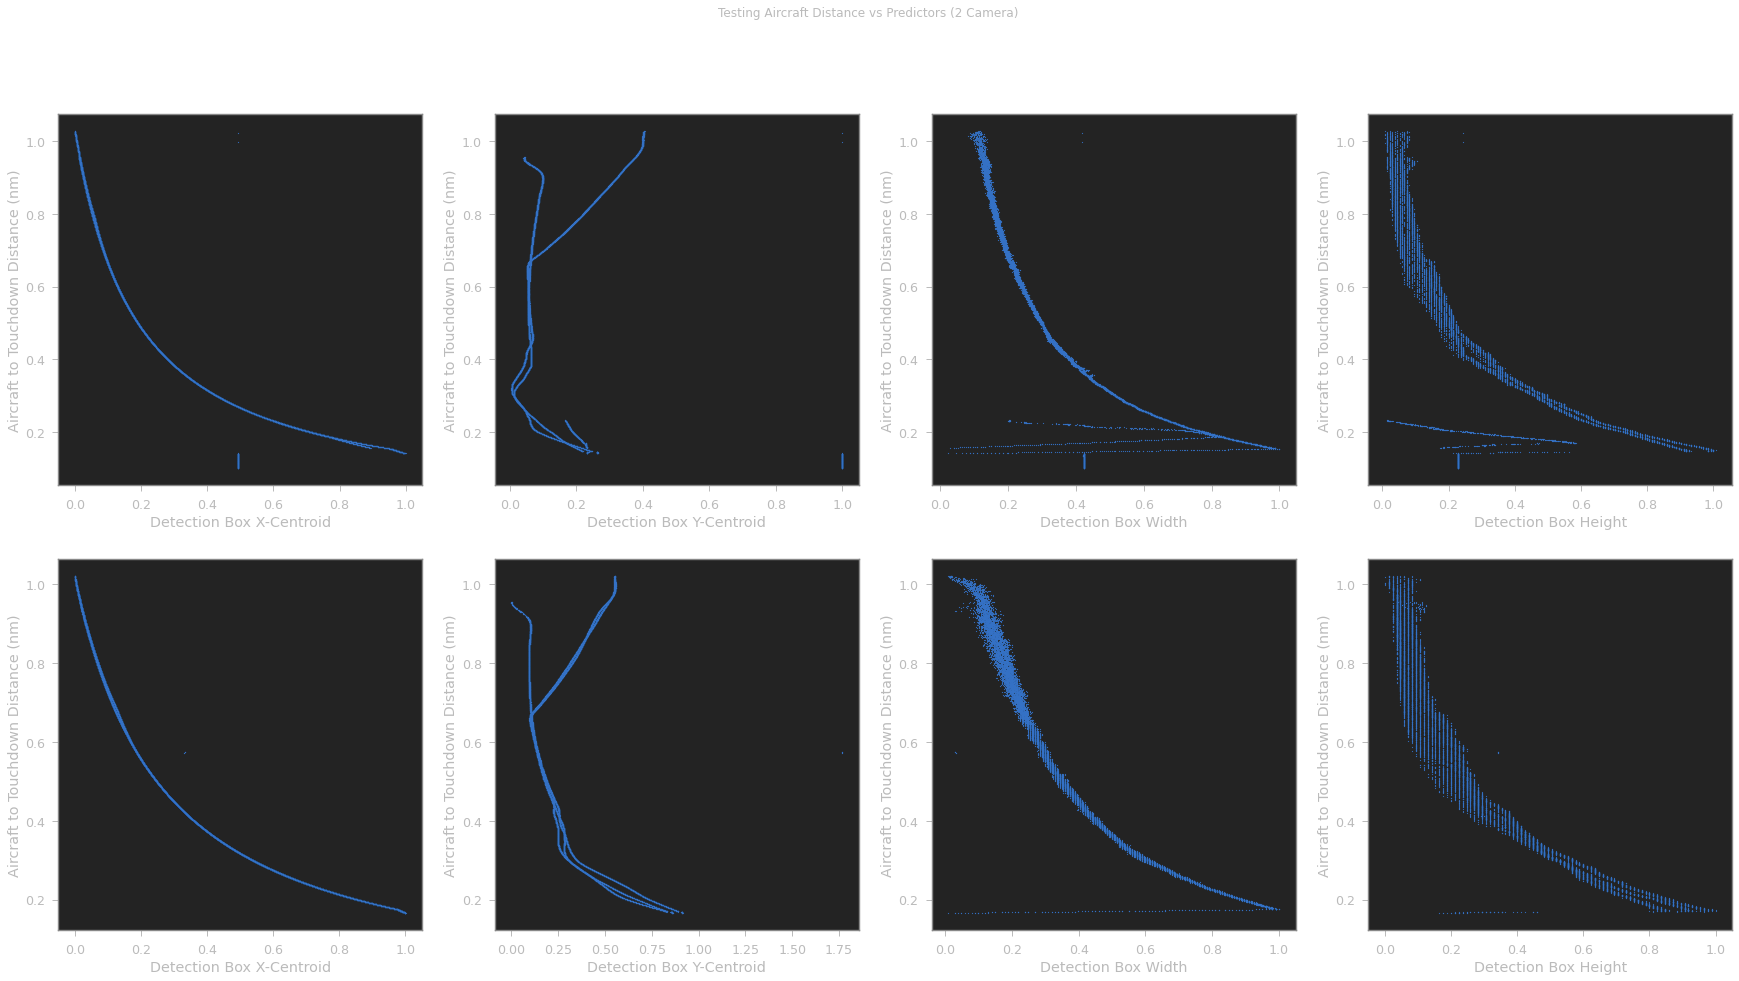

In [14]:
titles = ["Detection Box X-Centroid", "Detection Box Y-Centroid", "Detection Box Width", "Detection Box Height"]
fig, ax = plt.subplots(2,4,figsize=(30,15))
fig.suptitle("Training Aircraft Distance vs Predictors (2 Camera)")
for i in range(0,4):
    ax[0][i].scatter(X_train_1[:, i], Y_train_1, s=1)
    ax[0][i].set_xlabel(titles[i])
    ax[0][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")
for i in range(0,4):
    ax[1][i].scatter(X_train_2[:, i], Y_train_2, s=1)
    ax[1][i].set_xlabel(titles[i])
    ax[1][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")

fig, ax = plt.subplots(2,4,figsize=(30,15))
fig.suptitle("Testing Aircraft Distance vs Predictors (2 Camera)")
for i in range(0,4):
    ax[0][i].scatter(test_data['single']['cam_1']['x'][:, i].cpu().detach().numpy(), test_data['single']['cam_1']['y'][:, 0].cpu().detach().numpy(), s=1)
    ax[0][i].set_xlabel(titles[i])
    ax[0][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")
for i in range(0,4):
    ax[1][i].scatter(test_data['single']['cam_2']['x'][:, i].cpu().detach().numpy(), test_data['single']['cam_2']['y'][:, 0].cpu().detach().numpy(), s=1)
    ax[1][i].set_xlabel(titles[i])
    ax[1][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")

Data Statistic:
          Camera 1:
          Mean: [0.19101892411708832, 0.04624661058187485, 0.23863928020000458, 0.161183699965477]
          Std : [0.24890540540218353, 0.2908424735069275, 0.25386908650398254, 0.2399858832359314]
          
          Camera 2:
          Mean: [0.22113540768623352, 0.12611186504364014, 0.26530587673187256, 0.1844675987958908]
          Std : [0.25682532787323, 0.42740118503570557, 0.2785913050174713, 0.2537324130535126]
          
Data Statistic:
          Camera 1:
          Mean: [0.17446725070476532, -0.012509922496974468, 0.19903448224067688, 0.12914852797985077]
          Std : [0.2501801550388336, 0.3267986476421356, 0.2563011944293976, 0.2437313199043274]
          
          Camera 2:
          Mean: [0.2224167436361313, 0.10093619674444199, 0.26754945516586304, 0.19287000596523285]
          Std : [0.25625601410865784, 0.41074901819229126, 0.2785138487815857, 0.2622748017311096]
          


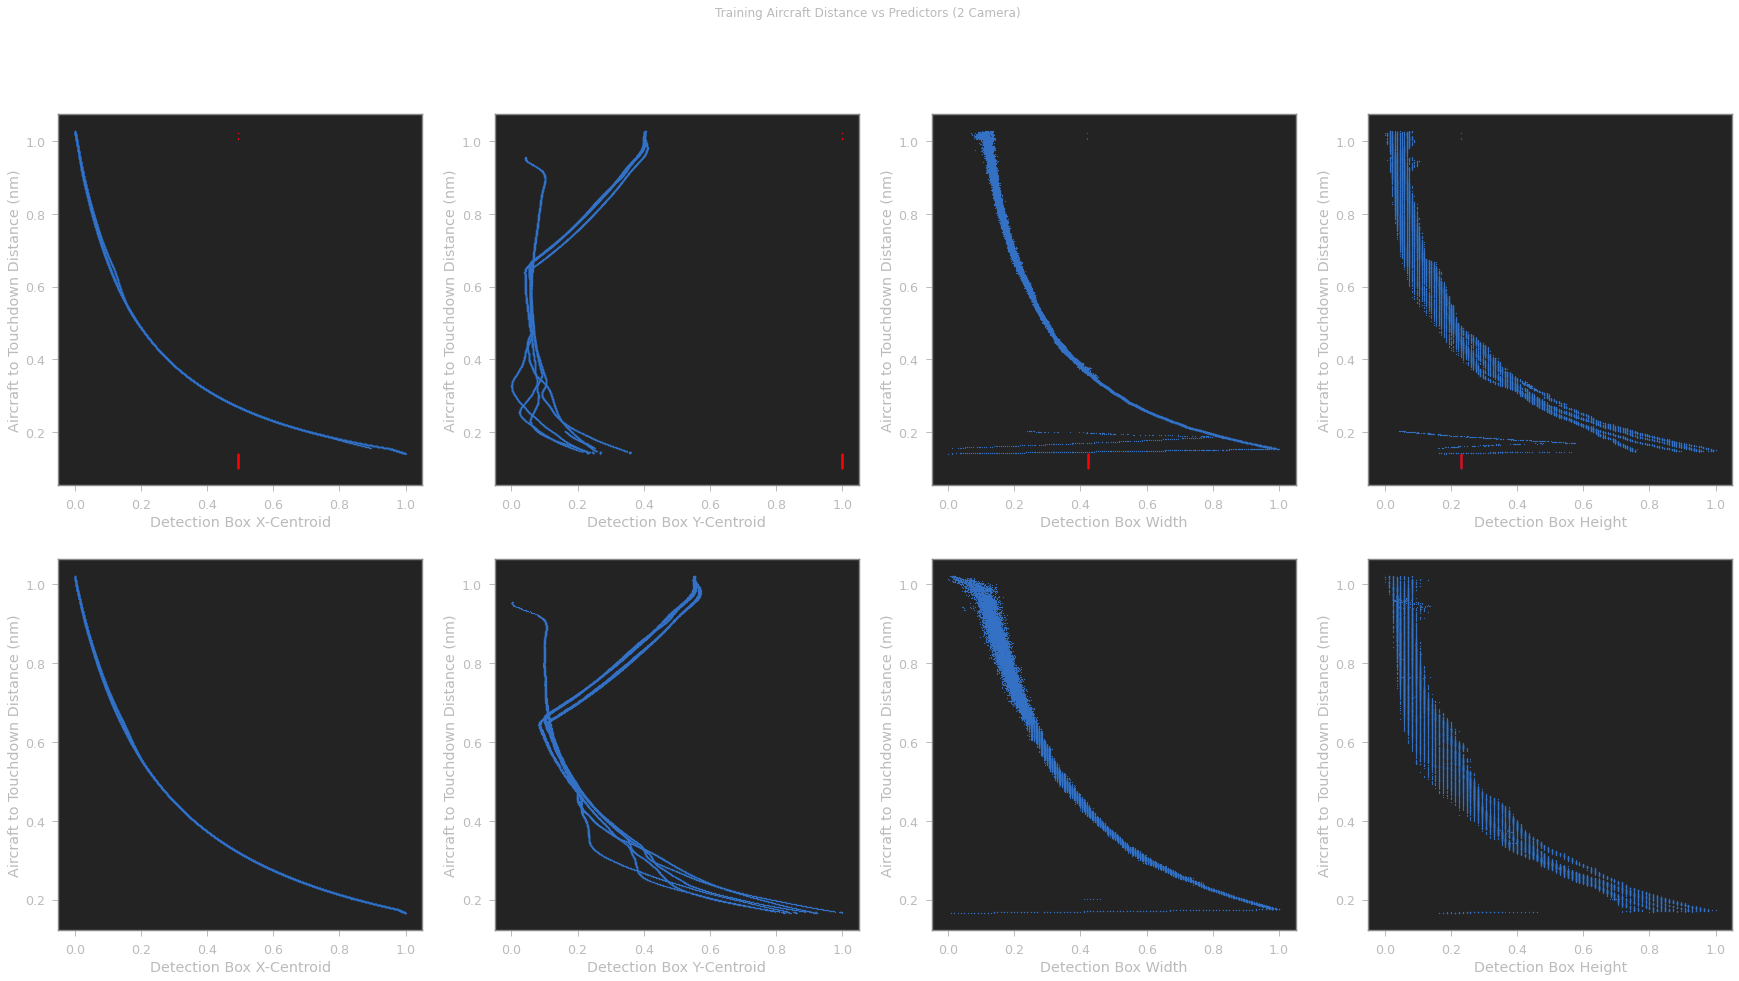

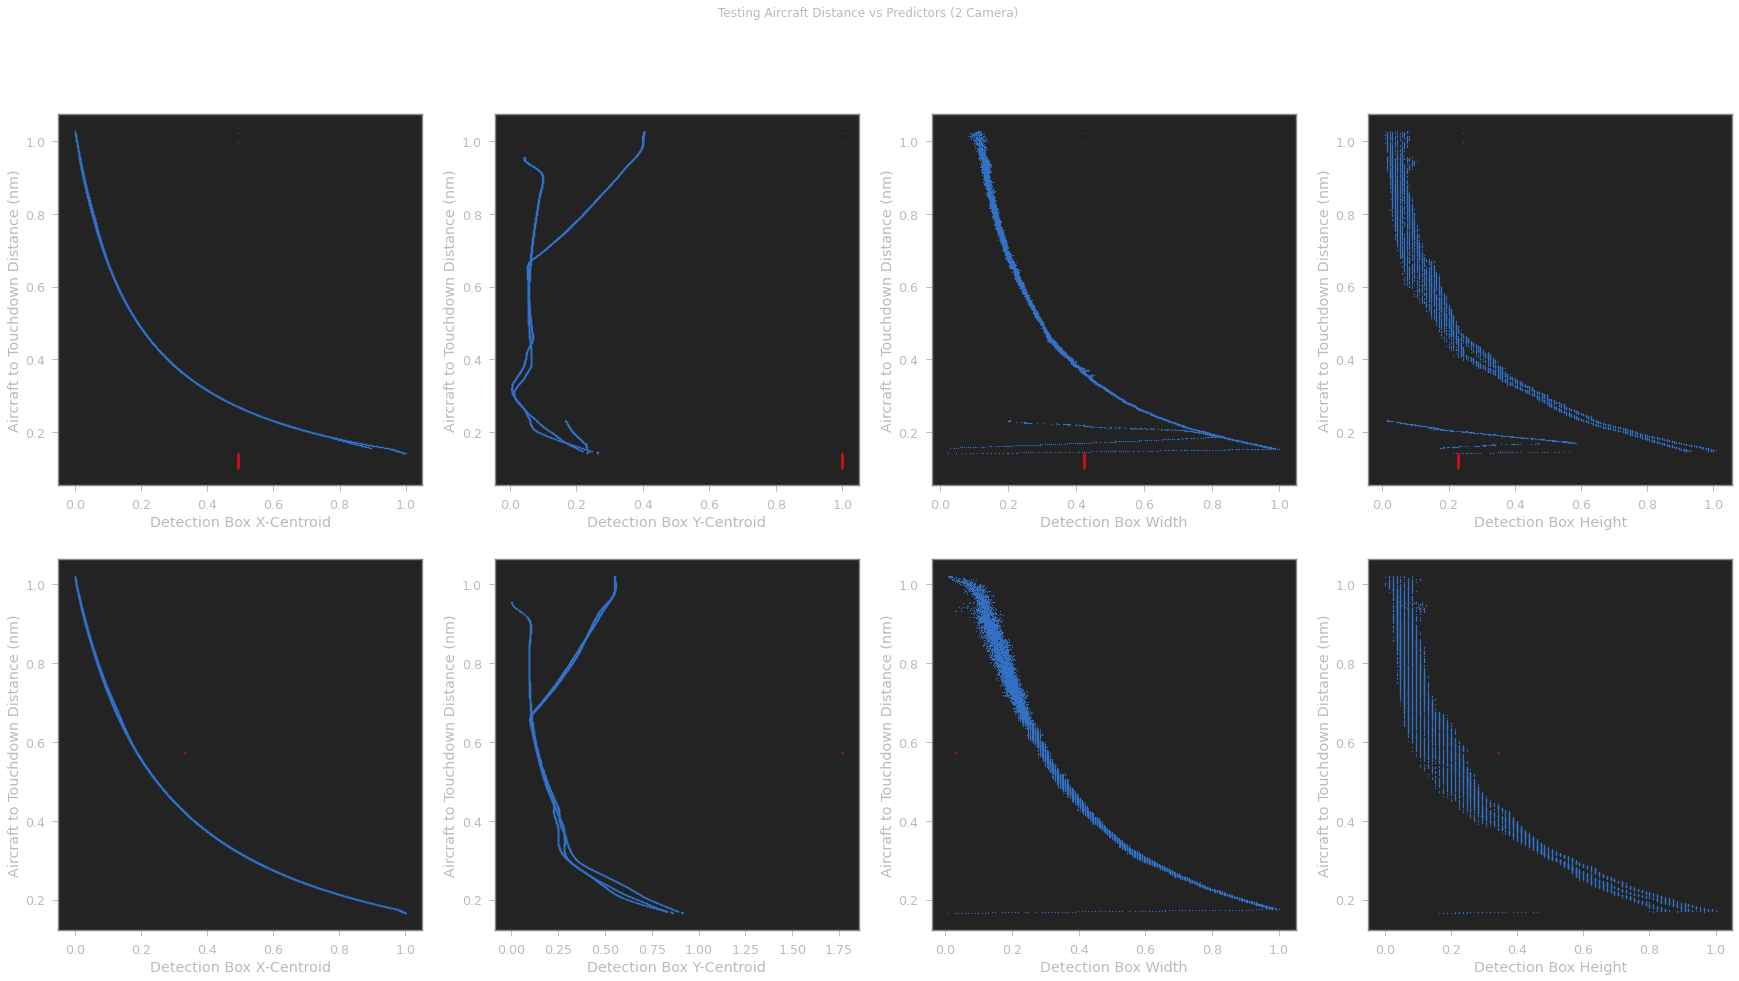

In [21]:
###### ee = EllipticEnvelope(random_state=0, contamination=0.015)
#ff_1 = ee.fit_predict(X_train_1[:, 1:2])>0
ff_train_1 = train_data['single']['cam_1']['x'][:, 1] < 0.75
ff_train_2 = train_data['single']['cam_2']['x'][:, 1] < 1.5
ff_test_1 = test_data['single']['cam_1']['x'][:, 1] < 0.75
ff_test_2 = test_data['single']['cam_2']['x'][:, 1] < 1.5


titles = ["Detection Box X-Centroid", "Detection Box Y-Centroid", "Detection Box Width", "Detection Box Height"]
fig, ax = plt.subplots(2,4,figsize=(30,15))
fig.suptitle("Training Aircraft Distance vs Predictors (2 Camera)")
for i in range(0,4):
    ax[0][i].scatter(train_data['single']['cam_1']['x'][:, i].cpu().detach().numpy(), train_data['single']['cam_1']['y'][:, 0].cpu().detach().numpy(), s=1)
    ax[0][i].scatter(train_data['single']['cam_1']['x'][:, i][torch.logical_not(ff_train_1)].cpu().detach().numpy(), train_data['single']['cam_1']['y'][:, 0][torch.logical_not(ff_train_1)].cpu().detach().numpy(), s=1, c='red')
    ax[0][i].set_xlabel(titles[i])
    ax[0][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")
for i in range(0,4):
    ax[1][i].scatter(train_data['single']['cam_2']['x'][:, i].cpu().detach().numpy(), train_data['single']['cam_2']['y'][:, 0].cpu().detach().numpy(), s=1)
    ax[1][i].scatter(train_data['single']['cam_2']['x'][:, i][torch.logical_not(ff_train_2)].cpu().detach().numpy(), train_data['single']['cam_2']['y'][:, 0][torch.logical_not(ff_train_2)].cpu().detach().numpy(), s=1, color = 'red')
    ax[1][i].set_xlabel(titles[i])
    ax[1][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")

fig, ax = plt.subplots(2,4,figsize=(30,15))
fig.suptitle("Testing Aircraft Distance vs Predictors (2 Camera)")
for i in range(0,4):
    ax[0][i].scatter(test_data['single']['cam_1']['x'][:, i].cpu().detach().numpy(), test_data['single']['cam_1']['y'][:, 0].cpu().detach().numpy(), s=1)
    ax[0][i].scatter(test_data['single']['cam_1']['x'][:, i][torch.logical_not(ff_test_1)].cpu().detach().numpy(), test_data['single']['cam_1']['y'][:, 0][torch.logical_not(ff_test_1)].cpu().detach().numpy(), s=1, color = 'red')
    ax[0][i].set_xlabel(titles[i])
    ax[0][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")
for i in range(0,4):
    ax[1][i].scatter(test_data['single']['cam_2']['x'][:, i].cpu().detach().numpy(), test_data['single']['cam_2']['y'][:, 0].cpu().detach().numpy(), s=1)
    ax[1][i].scatter(test_data['single']['cam_2']['x'][:, i][torch.logical_not(ff_test_2)].cpu().detach().numpy(), test_data['single']['cam_2']['y'][:, 0][torch.logical_not(ff_test_2)].cpu().detach().numpy(), s=1, color = 'red')
    ax[1][i].set_xlabel(titles[i])
    ax[1][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")

norm_offset = [[20.7227, 271.4375,   9.0000,   5.5000], [5.3496, 248.5000,  10.1094,   4.5000]]
norm_divider = [[1894.2773,  798.0625,  174.2500,   67.5000], [1908.6504,  396.5000,   99.8906,   42.5000]]
train_data = load_compiled_data(ts=[1,2,5],ws=[1],rs=[1,2], offset = norm_offset, divider = norm_divider, trajectory_threshold=[0.75, 1.5], device = device)
test_data = load_compiled_data(ts=[1,2,5],ws=[1],rs=[3], offset = norm_offset, divider = norm_divider, trajectory_threshold=[0.75, 1.5], device = device)


In [24]:
learning_rate = 1e-6
criterion = nn.MSELoss()
cam_1_complete_optimizer = torch.optim.Adam(list(reg_camera_1.parameters()) + list(aux_head.parameters()), lr=learning_rate)
cam_2_complete_optimizer = torch.optim.Adam(list(reg_camera_2.parameters()) + list(aux_head.parameters()), lr=learning_rate)
cam_1_neck_optimizer = torch.optim.Adam(reg_camera_1.parameters(), lr=learning_rate)
cam_2_neck_optimizer =  torch.optim.Adam(reg_camera_2.parameters(), lr=learning_rate)

In [28]:
mapes_train = []
mapes_test= []

In [29]:
reg_camera_1.train()
reg_camera_2.train()
aux_head.train()

epochs = tqdm.tqdm(iterable=range(700000), leave=True)
for epoch in epochs:
    optimizer_1.zero_grad()
    optimizer_2.zero_grad()
    #optimizer_1_reg.zero_grad()
    #optimizer_2_reg.zero_grad()
    # camera_1
    loss_1 = criterion(aux_head(reg_camera_1(train_data['single']['cam_1']['x'])).squeeze(), train_data['single']['cam_1']['y'][:, 0]) * 10
    loss_1.backward()
    optimizer_1.step()
    #optimized_1_reg.step()
    # camera_2
    loss_2 = criterion(aux_head(reg_camera_2(train_data['single']['cam_2']['x'])).squeeze(), train_data['single']['cam_2']['y'][:, 0]) * 10
    loss_2.backward()
    optimizer_2.step()
    if epoch % 500 == 0:
        reg_camera_1.eval()
        reg_camera_2.eval()
        aux_head.eval()
        ypred_1 = aux_head(reg_camera_1(test_data['single']['cam_1']['x'])).squeeze()
        ypred_2 = aux_head(reg_camera_2(test_data['single']['cam_2']['x'])).squeeze()
        
        ypred_1_train = aux_head(reg_camera_1(train_data['single']['cam_1']['x'])).squeeze()
        ypred_2_train = aux_head(reg_camera_2(train_data['single']['cam_2']['x'])).squeeze()
        
        tloss_1 = criterion(ypred_1, test_data['single']['cam_1']['y'][:, 0]) * 10
        tloss_2 = criterion(ypred_2, test_data['single']['cam_2']['y'][:, 0]) * 10
        
        mape_test_1 = ((abs(ypred_1-test_data['single']['cam_1']['y'][:, 0])/ypred_1).mean() * 100).item()
        mape_test_2 = ((abs(ypred_2-test_data['single']['cam_2']['y'][:, 0])/ypred_2).mean() * 100).item()
        
        mape_train_1 = ((abs(ypred_1_train-train_data['single']['cam_1']['y'][:, 0])/ypred_1_train).mean() * 100).item()
        mape_train_2 = ((abs(ypred_2_train-train_data['single']['cam_2']['y'][:, 0])/ypred_2_train).mean() * 100).item()
        
        display.clear_output(wait=True)
        display.display(epochs.container)
        print("==========================\nEpoch {}".format(epoch))
        print(f'Train Camera 1 Loss : {loss_1.item()}')
        print(f'Train Camera 2 Loss : {loss_2.item()}\n')
        print(f'Test Camera 1 Loss  : {tloss_1.item()}')
        print(f'Test Camera 2 Loss  : {tloss_2.item()}\n')
        
        print(f'Train Camera 1 MAPE : {mape_train_1:.2f}%')
        print(f'Train Camera 2 MAPE : {mape_train_2:.2f}%\n')
        
        print(f'Test Camera 1 MAPE  : {mape_test_1:.2f}%')
        print(f'Test Camera 2 MAPE  : {mape_test_2:.2f}%')
        print("==========================\n")
        mapes_train.append([mape_train_1, mape_train_2])
        mapes_test.append([mape_test_1, mape_test_2])
        reg_camera_1.train()
        reg_camera_2.train()
        aux_head.train()

  0%|          | 0/700000 [00:00<?, ?it/s]

Epoch 0
Train Camera 1 Loss : 3.2533323764801025
Train Camera 2 Loss : 3.2253847122192383

Test Camera 1 Loss  : 3.071253776550293
Test Camera 2 Loss  : 3.178673028945923

Train Camera 1 MAPE : 940.24%
Train Camera 2 MAPE : 879.04%

Test Camera 1 MAPE  : 910.48%
Test Camera 2 MAPE  : 873.69%



KeyboardInterrupt: 

In [67]:
torch.save(reg_camera_1.state_dict(), 'models/head/reg_camera_1.pt')
torch.save(reg_camera_2.state_dict(), 'models/head/reg_camera_2.pt')
torch.save(aux_head.state_dict(), 'models/head/aux_head.pt')

In [57]:
reg_camera_1.load_state_dict(torch.load('models/head/reg_camera_1.pt'))
reg_camera_2.load_state_dict(torch.load('models/head/reg_camera_2.pt'))
aux_head.load_state_dict(torch.load('models/head/aux_head.pt'))

<All keys matched successfully>

In [22]:
learning_rate = 1e-6
optimizer_camera_2 = torch.optim.Adam(reg_camera_2.parameters(), lr=learning_rate)
optimizer_camera_1 = torch.optim.Adam(reg_camera_1.parameters(), lr=learning_rate)

In [27]:
reg_camera_1.train()
reg_camera_2.train()
aux_head.train()

epochs = tqdm.tqdm(iterable=range(700000), leave=True)
for epoch in epochs:
    #optimizer_camera_1.zero_grad()
    #optimizer_camera_2.zero_grad()
    # camera_1
    loss_1 = criterion(aux_head(reg_camera_1(train_camera_1_x)).squeeze(), train_camera_1_y[:, 0]) * 10
    loss_1.backward()
    optimizer_camera_1.step()
    #optimized_1_reg.step()
    # camera_2
    loss_2 = criterion(aux_head(reg_camera_2(train_camera_2_x)).squeeze(), train_camera_2_y[:, 0]) * 10
    loss_2.backward()
    optimizer_camera_2.step()
    
    if epoch % 500 == 0:
        reg_camera_1.eval()
        reg_camera_2.eval()
        aux_head.eval()
        ypred_1 = aux_head(reg_camera_1(test_camera_1_x)).squeeze()
        ypred_2 = aux_head(reg_camera_2(test_camera_2_x)).squeeze()
        
        ypred_1_train = aux_head(reg_camera_1(train_camera_1_x)).squeeze()
        ypred_2_train = aux_head(reg_camera_2(train_camera_2_x)).squeeze()
        
        tloss_1 = criterion(ypred_1, test_camera_1_y[:, 0]) * 10
        tloss_2 = criterion(ypred_2, test_camera_2_y[:, 0]) * 10
        
        mape_test_1 = ((abs(ypred_1-test_camera_1_y[:, 0])/ypred_1).mean() * 100).item()
        mape_test_2 = ((abs(ypred_2-test_camera_2_y[:, 0])/ypred_2).mean() * 100).item()
        
        mape_train_1 = ((abs(ypred_1_train-train_camera_1_y[:, 0])/ypred_1_train).mean() * 100).item()
        mape_train_2 = ((abs(ypred_2_train-train_camera_2_y[:, 0])/ypred_2_train).mean() * 100).item()
        
        display.clear_output(wait=True)
        display.display(epochs.container)
        print("==========================\nEpoch {}".format(epoch))
        print(f'Train Camera 1 Loss : {loss_1.item()}')
        print(f'Train Camera 2 Loss : {loss_2.item()}\n')
        print(f'Test Camera 1 Loss  : {tloss_1.item()}')
        print(f'Test Camera 2 Loss  : {tloss_2.item()}\n')
        
        print(f'Train Camera 1 MAPE : {mape_train_1:.2f}%')
        print(f'Train Camera 2 MAPE : {mape_train_2:.2f}%\n')
        
        print(f'Test Camera 1 MAPE  : {mape_test_1:.2f}%')
        print(f'Test Camera 2 MAPE  : {mape_test_2:.2f}%')
        print("==========================\n")
        mapes_train.append([mape_train_1, mape_train_2])
        mapes_test.append([mape_test_1, mape_test_2])
        reg_camera_1.train()
        reg_camera_2.train()
        aux_head.train()

  0%|          | 976/1000000 [00:02<44:38, 372.93it/s]

Epoch 1000
Train Camera 1 Loss : 1.160769988928223e-05
Train Camera 2 Loss : 7.301544428628404e-06

Test Camera 1 Loss  : 3.3566277124919e-05
Test Camera 2 Loss  : 4.595389691530727e-05

Test Camera 1 MAPE  : 0.15%
Test Camera 2 MAPE  : 0.17%



KeyboardInterrupt: 

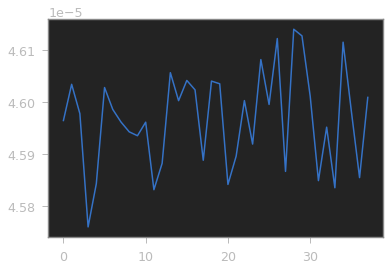

In [26]:
plt.plot(np.array(tlosses)[:, 1])

# Old Model Test

In [21]:
def load_compiled_data_custom(ts=[1], ws=[1], rs=[1], offset = [[0,0,0,0],[0,0,0,0]], divider = [[1,1,1,1],[1,1,1,1]], device = torch.device('cpu')):
    camera_1_dets = []
    camera_2_dets = []
    camera_1_ys = []
    camera_2_ys = []

    offset = torch.tensor(offset, device =device)
    divider = torch.tensor(divider, device =device)

    for t in ts:
        for w in ws:
            for r in rs:
                with open(f"output/object_detector/t{t}w{w}r{r}.pkl", 'rb') as f:
                        box, scores, gt_distance = pkl.load(f)
                gt_distance = torch.from_numpy(gt_distance)
                camera_1_det = torch.cat(((box[:, :4].float()[:len(gt_distance)]), gt_distance[:, 0].unsqueeze(1) / 10, scores[:, 0].unsqueeze(1)), axis = 1)
                camera_2_det = torch.cat(((box[:, 4:].float()[:len(gt_distance)]), gt_distance[:, 0].unsqueeze(1) / 10, scores[:, 1].unsqueeze(1)), axis = 1)
                
                # Remove Missing Detection
                
                f_camera_1_available_detection = torch.all(torch.logical_not(camera_1_det[:, :4] == 0), dim = 1)
                f_camera_2_available_detection = torch.all(torch.logical_not(camera_2_det[:, :4] == 0), dim = 1)
                f_camera_1_gt_more_than_1nm = camera_1_det[:, -2] > 0.1
                f_camera_2_gt_more_than_1nm = camera_2_det[:, -2] > 0.1
                f_camera_all_available_detection = torch.logical_and(f_camera_1_available_detection, f_camera_2_available_detection)
                
                
                #f_camera_1 = torch.logical_and(f_camera_1_available_detection, f_camera_1_gt_more_than_1nm)
                #f_camera_2 = torch.logical_and(f_camera_2_available_detection, f_camera_2_gt_more_than_1nm)
                
                
                camera_1_det = camera_1_det[f_camera_all_available_detection].float()
                camera_2_det = camera_2_det[f_camera_all_available_detection].float()
    

                camera_1_dets.append(camera_1_det[:, :4])
                camera_1_ys.append(camera_1_det[:, -2:])
                camera_2_dets.append(camera_2_det[:, :4])
                camera_2_ys.append(camera_2_det[:, -2:])
                
    camera_1_y = torch.cat(camera_1_ys).to(device)
    camera_2_y = torch.cat(camera_2_ys).to(device)      
    camera_1_dets = torch.cat(camera_1_dets)
    camera_2_dets = torch.cat(camera_2_dets)
    
    # Convert to (X_centroid, Y_centroid, X_width, Y_width)
    camera_1_x = torch.zeros(camera_1_dets[:, :4].shape, device = device)
    camera_2_x = torch.zeros(camera_2_dets[:, :4].shape, device = device)
    camera_1_x[:, 0] = (camera_1_dets[:, 0] + camera_1_dets[:, 2]) / 2
    camera_1_x[:, 1] = (camera_1_dets[:, 1] + camera_1_dets[:, 3]) / 2
    camera_1_x[:, 2] = (camera_1_dets[:, 2] - camera_1_dets[:, 0])
    camera_1_x[:, 3] = (camera_1_dets[:, 3] - camera_1_dets[:, 1])
    camera_2_x[:, 0] = (camera_2_dets[:, 0] + camera_2_dets[:, 2]) / 2
    camera_2_x[:, 1] = (camera_2_dets[:, 1] + camera_2_dets[:, 3]) / 2
    camera_2_x[:, 2] = (camera_2_dets[:, 2] - camera_2_dets[:, 0])
    camera_2_x[:, 3] = (camera_2_dets[:, 3] - camera_2_dets[:, 1])
    
    camera_1_x = (camera_1_x - offset[0]) / divider[0]
    camera_2_x = (camera_2_x - offset[1]) / divider[1]
    
    print(f"""Data Statistic:
          Camera 1:
          Mean: {torch.mean(camera_1_x, 0).tolist()}
          Std : {torch.std(camera_1_x, 0).tolist()}
          
          Camera 2:
          Mean: {torch.mean(camera_2_x, 0).tolist()}
          Std : {torch.std(camera_2_x, 0).tolist()}
          """)
    return camera_1_x, camera_1_y, camera_2_x, camera_2_y

In [30]:
norm_offset = [[20.7227, 271.4375,   9.0000,   5.5000], [5.3496, 248.5000,  10.1094,   4.5000]]
norm_divider = [[1894.2773,  798.0625,  174.2500,   67.5000], [1908.6504,  396.5000,   99.8906,   42.5000]]
train_camera_1_x, train_camera_1_y, train_camera_2_x, train_camera_2_y = load_compiled_data_custom(ts=[1,2,5],ws=[1],rs=[1,2], offset = norm_offset, divider = norm_divider, device = device)
test_camera_1_x, test_camera_1_y, test_camera_2_x, test_camera_2_y = load_compiled_data_custom(ts=[1,2,5],ws=[1],rs=[3], offset = norm_offset, divider = norm_divider, device = device)

Data Statistic:
          Camera 1:
          Mean: [0.23115402460098267, 0.13664153218269348, 0.3269054591655731, 0.23455950617790222]
          Std : [0.21913321316242218, 0.10741851478815079, 0.20001117885112762, 0.20704865455627441]
          
          Camera 2:
          Mean: [0.28849586844444275, 0.3268456757068634, 0.3711751103401184, 0.2691517174243927]
          Std : [0.26450350880622864, 0.19246098399162292, 0.23262810707092285, 0.2345651388168335]
          
Data Statistic:
          Camera 1:
          Mean: [0.24771815538406372, 0.10636551678180695, 0.3369009792804718, 0.24522686004638672]
          Std : [0.23109997808933258, 0.09466056525707245, 0.20359617471694946, 0.21714016795158386]
          
          Camera 2:
          Mean: [0.30855682492256165, 0.2939678430557251, 0.3898959457874298, 0.29688432812690735]
          Std : [0.2778509855270386, 0.2029714286327362, 0.24246175587177277, 0.25780919194221497]
          


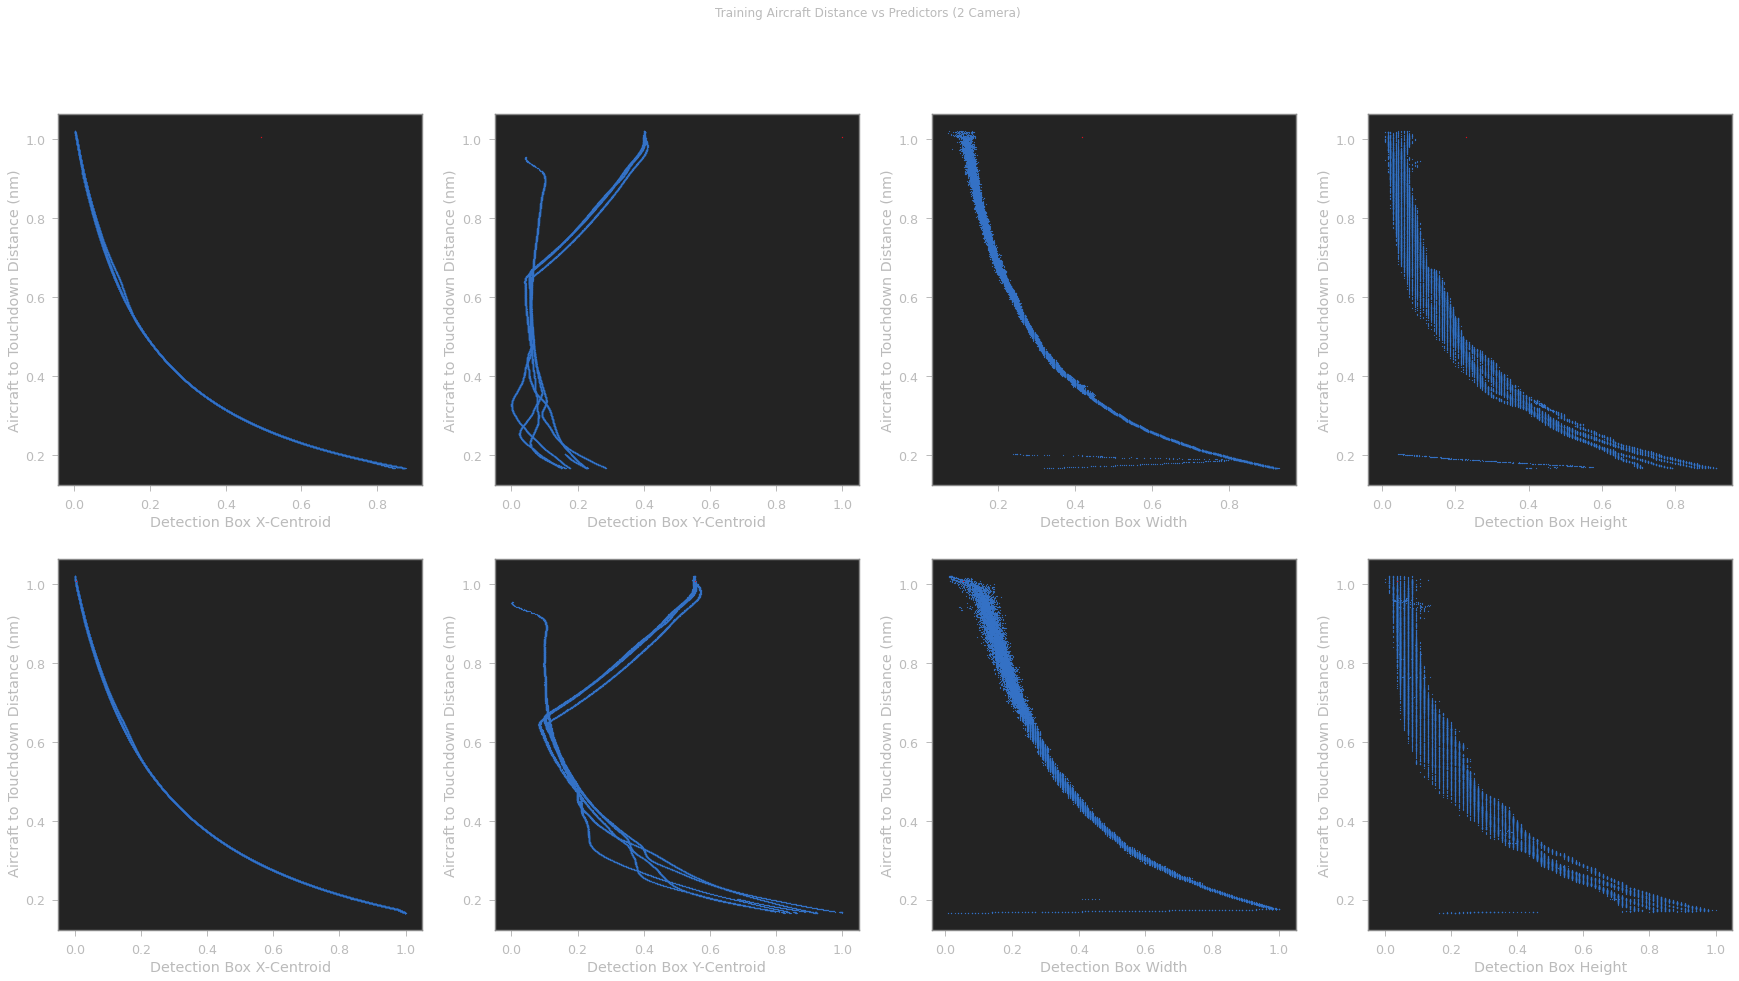

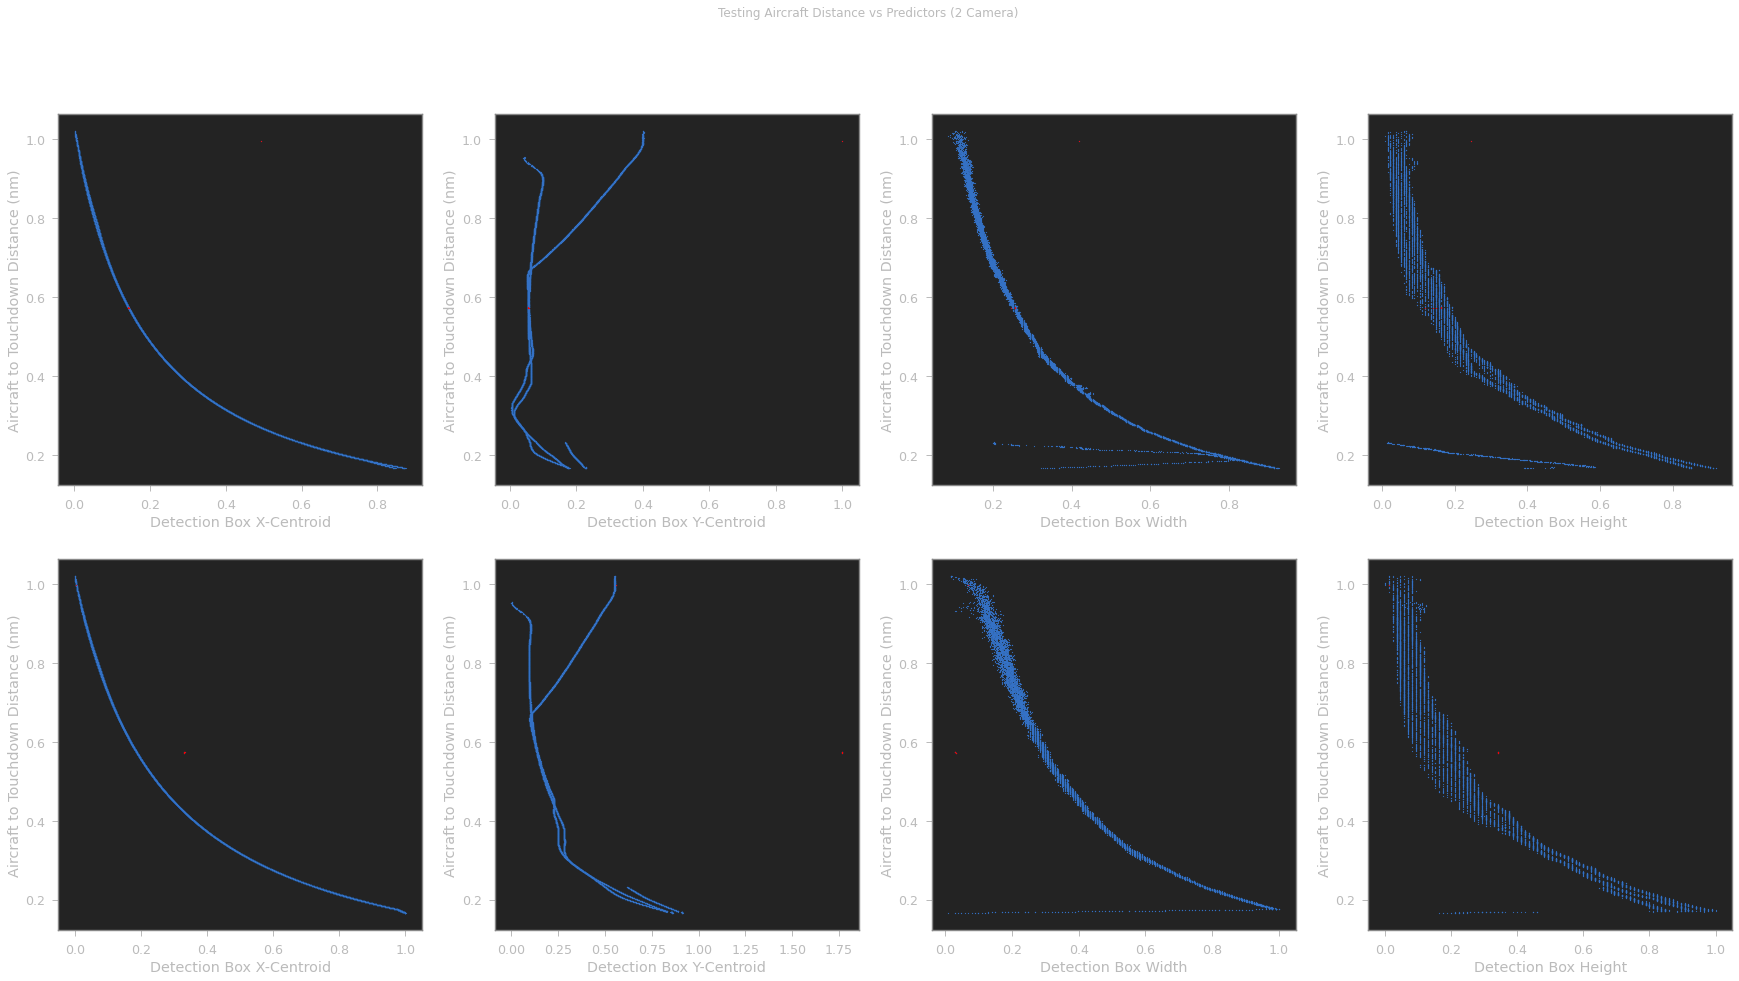

In [31]:
#ee = EllipticEnvelope(random_state=0, contamination=0.015)
#ff_1 = ee.fit_predict(X_train_1[:, 1:2])>0
ff_train_1 = train_camera_1_x[:, 1] < 0.75
ff_train_2 = train_camera_2_x[:, 1] < 1.5
ff_train = torch.logical_and(ff_train_1, ff_train_2)
ff_test_1 = test_camera_1_x[:, 1] < 0.75
ff_test_2 = test_camera_2_x[:, 1] < 1.5
ff_test = torch.logical_and(ff_test_1, ff_test_2)


titles = ["Detection Box X-Centroid", "Detection Box Y-Centroid", "Detection Box Width", "Detection Box Height"]
fig, ax = plt.subplots(2,4,figsize=(30,15))
fig.suptitle("Training Aircraft Distance vs Predictors (2 Camera)")
for i in range(0,4):
    ax[0][i].scatter(train_camera_1_x[:, i].cpu().detach().numpy(), train_camera_1_y[:, 0].cpu().detach().numpy(), s=1)
    ax[0][i].scatter(train_camera_1_x[:, i][torch.logical_not(ff_train)].cpu().detach().numpy(), train_camera_1_y[:, 0][torch.logical_not(ff_train)].cpu().detach().numpy(), s=1, c='red')
    ax[0][i].set_xlabel(titles[i])
    ax[0][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")
for i in range(0,4):
    ax[1][i].scatter(train_camera_2_x[:, i].cpu().detach().numpy(), train_camera_2_y[:, 0].cpu().detach().numpy(), s=1)
    ax[1][i].scatter(train_camera_2_x[:, i][torch.logical_not(ff_train)].cpu().detach().numpy(), train_camera_2_y[:, 0][torch.logical_not(ff_train)].cpu().detach().numpy(), s=1, color = 'red')
    ax[1][i].set_xlabel(titles[i])
    ax[1][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")

fig, ax = plt.subplots(2,4,figsize=(30,15))
fig.suptitle("Testing Aircraft Distance vs Predictors (2 Camera)")
for i in range(0,4):
    ax[0][i].scatter(test_camera_1_x[:, i].cpu().detach().numpy(), test_camera_1_y[:, 0].cpu().detach().numpy(), s=1)
    ax[0][i].scatter(test_camera_1_x[:, i][torch.logical_not(ff_test)].cpu().detach().numpy(), test_camera_1_y[:, 0][torch.logical_not(ff_test)].cpu().detach().numpy(), s=1, color = 'red')
    ax[0][i].set_xlabel(titles[i])
    ax[0][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")
for i in range(0,4):
    ax[1][i].scatter(test_camera_2_x[:, i].cpu().detach().numpy(), test_camera_2_y[:, 0].cpu().detach().numpy(), s=1)
    ax[1][i].scatter(test_camera_2_x[:, i][torch.logical_not(ff_test)].cpu().detach().numpy(), test_camera_2_y[:, 0][torch.logical_not(ff_test)].cpu().detach().numpy(), s=1, color = 'red')
    ax[1][i].set_xlabel(titles[i])
    ax[1][i].set_ylabel(f"Aircraft to Touchdown Distance (nm)")
    
ff_1 = train_camera_1_x[:, 1] < 0.75
ff_2 = train_camera_2_x[:, 1] < 1.5
train_camera_1_x = train_camera_1_x[ff_train]
train_camera_1_y = train_camera_1_y[ff_train]
train_camera_2_x = train_camera_2_x[ff_train]
train_camera_2_y = train_camera_2_y[ff_train]
test_camera_1_x = test_camera_1_x[ff_test]
test_camera_1_y = test_camera_1_y[ff_test]
test_camera_2_x = test_camera_2_x[ff_test]
test_camera_2_y = test_camera_2_y[ff_test]

In [37]:
train_x = torch.cat((train_camera_1_x, train_camera_2_x), dim = 1)
test_x = torch.cat((test_camera_1_x, test_camera_2_x), dim = 1)

In [49]:
model = mlp_dual().to(device)
learning_rate = 1e-4
criterion = nn.MSELoss()
optimizer= torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.01)

In [52]:
model.train()
losses = []
tlosses = []
epochs = tqdm.tqdm(iterable=range(500000), leave=True)
for epoch in epochs:
    optimizer.zero_grad()
    # camera_1
    loss = criterion(model(train_x).squeeze(), train_camera_1_y[:, 0]) * 100
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        model.eval()
        ypred = model(test_x).squeeze()
        tloss = criterion(ypred, test_camera_1_y[:, 0]) * 100
        
        display.clear_output(wait=True)
        display.display(epochs.container)
        print("==========================\nEpoch {}".format(epoch))
        print(f'Train Loss : {loss_1.item()}\n')
        print(f'Test Loss  : {tloss_1.item()}\n')
        print(f'Test MAPE  : {((abs(ypred-test_camera_1_y[:, 0])/ypred).mean() * 100).item():.2f}%')
        print("==========================\n")
        losses.append([loss_1.item(), loss_2.item()])
        tlosses.append([tloss_1.item(),tloss_2.item()])
        model.train()

100%|#########9| 499500/500000 [21:16<00:01, 392.03it/s]

Epoch 499500
Train Loss : 0.0030526185873895884

Test Loss  : 0.0035261206794530153

Test MAPE  : 0.51%

